# Exercise 3<br> Multi-class Classification and Neural Networks

In [139]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo

# Load mat data

In [5]:
data = scipy.io.loadmat("ex3data1.mat")
weights = scipy.io.loadmat("ex3weights.mat")

In [146]:
X = data['X']
y = data['y']
numLabels = 10

m = X.shape[0]  # get sample num

In [7]:
rand_indices = np.random.permutation(list(range(m)))
sel = X[rand_indices[0:100], :]

# Visualize Data

In [71]:
# Taking much time in this way
def displayData_slow(X):
    
    
    m, n = X.shape
    
    example_width = int(np.round(np.sqrt(n)))
    example_height = int(n / example_width)
    
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    
    for i in range(m):
        
        plt.subplot(display_rows, display_cols, i+1)
        plt.tick_params(labelleft='off')
        plt.tick_params(labelbottom='off')
        
        plt.imshow(X[i].reshape(example_height, example_width).T, cmap='gray')
    
    plt.show()

In [76]:
# Faster
def displayData(X):
    
    
    m, n = X.shape
    
    example_width = int(np.round(np.sqrt(n)))
    example_height = int(n / example_width)
    
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    
    displayX = np.zeros((display_cols*example_height, display_rows*example_width))
    for i in range(display_cols):
        for j in range(display_rows):
            displayX[example_height*i : example_height*i+example_height, example_width*j:example_width*j+example_width] = X[i*10+j].reshape(example_height, example_width).T 

    
    plt.tick_params(labelleft='off')
    plt.tick_params(labelbottom='off')    
    plt.imshow(displayX, cmap='gray')
    
    plt.show()

In [67]:
test = np.zeros((10,10))
test[0:5,0:5] = np.ones((5,5))
test

array([[ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
sel

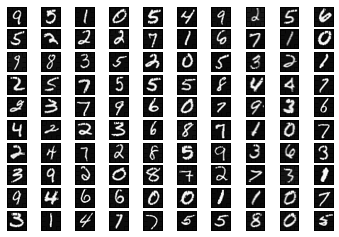

CPU times: user 10.9 s, sys: 142 ms, total: 11.1 s
Wall time: 11.6 s


In [74]:
%%time
displayData_slow(sel)

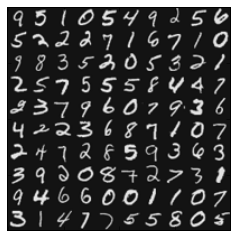

CPU times: user 184 ms, sys: 5.48 ms, total: 190 ms
Wall time: 190 ms


In [75]:
%%time
displayData(sel)

# Logistic Regression Cost Function

In [78]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [233]:
def lrCostFunction(theta, X, y, lamd):
    
    m = len(y)
    
    J = 0
    grad = np.zeros(theta.shape)
    
    J = (-y.T.dot(np.log(sigmoid(X.dot(theta))))-(1-y).T.dot(np.log(1-sigmoid(X.dot(theta)))) ) / m

    J = J + lamd  * sum(theta[1:]**2) / (2*m)
    print(X.shape)
    print(theta.shape)
    print(X.dot(theta).shape)
    print((sigmoid(X.dot(theta)).reshape(5000,1)).shape)
    print(y.shape)
    print((sigmoid(X.dot(theta)) - y).shape)
    grad = X.transpose().dot(sigmoid(X.dot(theta)) - y) / m
    
    tmp = theta.copy()
    tmp[0] = 0
    
    print(grad)
    print(tmp)
    grad = grad + (lamd / m) * tmp
    
    return J, grad

In [232]:
theta_t = np.array([-2, -1, 1, 2]).T
X_t = np.hstack( (np.ones((5,1)), np.array(range(1,16)).reshape(5, 3, order='F')/10 ))
y_t = ( np.array([1, 0, 1, 0, 1]).T >= 0.5 ).astype(float)
lambda_t = 3

J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

(5, 4)


ValueError: total size of new array must be unchanged

In [199]:
lrCostFunction(theta_t, X_t, y_t, lambda_t)[1]

[ 0.14656137  0.05144159  0.12472227  0.19800296]
[ 0 -1  1  2]


array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296])

In [200]:
grad

array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296])

### [memo]<br><br> In numpy, arr\*\*2 is faster than other ways? <br><br>http://stackoverflow.com/questions/25870923/how-to-square-or-raise-to-a-power-elementwise-a-2d-numpy-array

In [201]:
%timeit X**2

100 loops, best of 3: 6.92 ms per loop


In [202]:
%timeit X*X

100 loops, best of 3: 6.9 ms per loop


In [203]:
%timeit np.square(X)

100 loops, best of 3: 6.63 ms per loop


In [204]:
def lrCostFunctionJ(theta, X, y, lamd):
    J, grad = lrCostFunction(theta, X, y, lamd)
    return J

# One-vs-all Training

In [218]:
def oneVsAll(X, y, numLabels, lamd):
    m, n = X.shape
    allTheta = np.zeros((numLabels, n+1))
    
    X = np.append(np.ones((m,1)), X, 1)

    initialTheta = np.zeros((n+1, 1))
    
    for i in range(numLabels):
        allTheta[i,:] = spo.minimize(lrCostFunction, x0=initialTheta, args=(X, (y==i).astype(float), lamd), method='BFGS', options={'disp': True})
        
    return allTheta

In [234]:
lamd=0.1
optTheta = oneVsAll(X, y, numLabels, lamd)

(5000, 401)
(401,)
(5000,)
(5000, 1)
(5000, 1)
(5000, 5000)
[[  5.00000000e-01   5.00000000e-01   5.00000000e-01 ...,   5.00000000e-01
    5.00000000e-01   5.00000000e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.99628022e-06   1.99628022e-06   1.99628022e-06 ...,   1.99628022e-06
    1.99628022e-06   1.99628022e-06]
 [ -2.06052560e-07  -2.06052560e-07  -2.06052560e-07 ...,  -2.06052560e-07
   -2.06052560e-07  -2.06052560e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

ValueError: operands could not be broadcast together with shapes (401,5000) (401,) 

In [236]:
np.zeros((10,1)).shape

(10, 1)